In [1]:
from turtle import distance
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import config.config as config
from scipy import spatial
import time
from sklearn.metrics.pairwise import cosine_similarity
from rain_simulation.rain_simulation import apply_rain 

In [2]:
pc = pd.read_csv('../data/sample_id_194__s_curve_variable_velocity__rain_rate_0__pc.csv')
data = pd.read_csv('../data/sample_id_194__s_curve_variable_velocity__rain_rate_0__lidar__data.csv')
pc_array = np.stack([pc['pc_x'], pc['pc_y'], pc['reflect']], axis=1)
positions = np.stack([data['positions_x_ground_truth'], data['positions_y_ground_truth']], axis=1)

In [3]:
def apply_rain_2(position, rain_rate, pc_array, p_min): 
    p_min = 0.9/(np.pi * config.lidar_range**2)
    # get all points in range of lidar sensor
    subs = (position - pc_array[:,0:2])
    # calculate their range
    ranges = np.linalg.norm(subs, axis=1)
    angles = np.arctan2(subs[:,1], subs[:,0])

    ranges_in_range = ranges[ranges < config.lidar_range]
    angles_in_range = angles[ranges < config.lidar_range]
    
    reflectivities = pc_array[:,2][ranges < config.lidar_range]
    new_intensities = reflectivities/(ranges_in_range**2) * np.exp(-0.02*(rain_rate**0.6)*ranges_in_range)
    taken_ranges = ranges_in_range[new_intensities > p_min]
    taken_angles = angles_in_range[new_intensities > p_min]
    if (len(taken_ranges[taken_ranges < 0]) > 0): 
        taken_ranges[taken_ranges < 0] = 0
    taken_intensities = new_intensities[new_intensities > p_min]
    taken_ranges = taken_ranges + np.random.randn()*config.lidar_sensor_std_measurement

    noisy_ranges = -(taken_ranges + np.random.normal(0, 0.02*taken_ranges*(1-np.exp(-rain_rate))**2))
    print(noisy_ranges)
    points_after_rain = np.stack([noisy_ranges * np.cos(taken_angles), noisy_ranges * np.sin(taken_angles)], axis=1) + position

    return points_after_rain

[-10.78847875 -12.21535889 -10.79990268 -12.22209146 -10.78716129
 -11.74121209 -10.92593597 -11.99750966 -10.68765835 -12.27892879
 -10.98513025 -12.02129749 -10.97440425 -11.74373634 -10.75826653
 -12.36193913 -10.8169708  -12.26518413 -10.87583701 -11.90591267
 -10.82155012 -12.08686376 -10.84475989 -12.24984828 -10.74973714
 -12.0152668  -10.59245745 -11.74294115 -10.6116929  -11.9573899
 -10.67153899 -11.41667591 -10.62690728 -11.83082137 -10.47816381
 -11.57693309 -10.77614639 -11.89671103 -10.13785293 -12.2932409
 -10.39553254 -12.22053458 -10.61311881 -12.73719461 -10.88219602
 -11.54960412 -10.5685437  -12.15439353 -10.60443931 -12.42395005
 -10.60480042 -11.39453959 -10.40084555 -11.36719048 -10.43108648
 -11.60948976 -10.85941265 -11.04106324 -10.4023913  -11.58933822
 -10.67193935 -11.95328468 -10.55477928 -12.30318923 -10.45923612
 -11.9178782  -10.57421741 -11.61674988 -10.79789149 -11.32666736
 -10.4889626  -10.88576134 -10.24255794 -12.0470225  -10.46490607
 -11.4252761

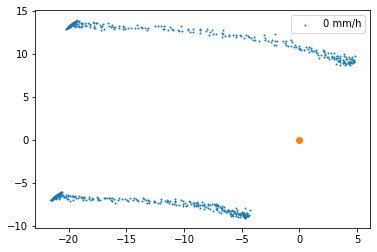

In [7]:
p_rain_rate_0 = apply_rain_2(positions[100], 0,pc_array, 0.9/(np.pi * config.lidar_range**2))
p_rain_rate_10 = apply_rain_2(positions[100], 10,pc_array, 0.9/(np.pi * config.lidar_range**2))
p_rain_rate_20 = apply_rain_2(positions[100], 20,pc_array, 0.9/(np.pi * config.lidar_range**2))
p_rain_rate_30 = apply_rain_2(positions[100], 30,pc_array, 0.9/(np.pi * config.lidar_range**2))
p_rain_rate_40 = apply_rain_2(positions[100], 40,pc_array, 0.9/(np.pi * config.lidar_range**2))



plt.scatter(p_rain_rate_0[:,0], p_rain_rate_0[:,1], s=1, label="0 mm/h")
#plt.scatter(p_rain_rate_10[:,0], p_rain_rate_10[:,1], s=1, label="10 mm/h")
#plt.scatter(p_rain_rate_20[:,0], p_rain_rate_20[:,1], s=1, label="20 mm/h")
#plt.scatter(p_rain_rate_30[:,0], p_rain_rate_30[:,1], s=1, label="30 mm/h")
#plt.scatter(p_rain_rate_40[:,0], p_rain_rate_40[:,1], s=1, label="40 mm/h")

#plt.scatter(pc_array[:,0], pc_array[:,1], alpha= 0.1)
plt.scatter(positions[0][0], positions[0][1])
plt.legend()

print(p_rain_rate_0.shape, p_rain_rate_10.shape, p_rain_rate_20.shape, p_rain_rate_30.shape, p_rain_rate_40.shape )

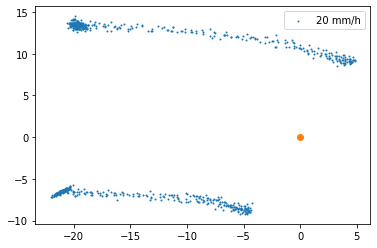

In [8]:
plt.scatter(p_rain_rate_20[:,0], p_rain_rate_20[:,1], s=1, label="20 mm/h")
plt.scatter(positions[0][0], positions[0][1])
plt.legend()

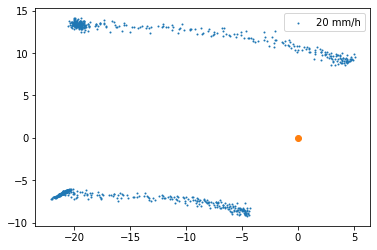

In [9]:
plt.scatter(p_rain_rate_30[:,0], p_rain_rate_30[:,1], s=1, label="20 mm/h")
plt.scatter(positions[0][0], positions[0][1])
plt.legend()

In [29]:
np.exp(0)

1.0

In [79]:
from queue import SimpleQueue
from statistics import median


def get_pc_similarity(starting_pos,position, position_2): 
   
    # get all points in range of lidar sensor
    subs = (position - pc_array[:,0:2])
    # calculate their range
    ranges = np.linalg.norm(subs, axis=1)
    in_range = np.array(subs[ranges<config.lidar_range])

    subs_2 = (position_2 - pc_array[:,0:2])
    # calculate their range
    ranges_2 = np.linalg.norm(subs_2, axis=1)
    in_range_2 = np.array(subs_2[ranges_2<config.lidar_range])
    
    distance_to_zero = spatial.distance.directed_hausdorff(np., in_range)[0]
    distance_to_zero_2 = spatial.distance.directed_hausdorff(in_range_start, in_range_2)[0]
    #print(distance_to_zero, distance_to_zero_2)
    return stats.norm(distance_to_zero, .2).pdf(distance_to_zero_2)
    #likelihoods = stats.norm(mode, config.lidar_sensor_std).pdf(mode_2)
    #likelihoods = stats.norm(mean, config.lidar_sensor_std).pdf(mean_2)
    
    


In [80]:
init_pos_index = 0
other_indicies = np.arange(init_pos_index, 399, 20)
for oi in other_indicies: 
    print(init_pos_index, " - ", oi, ": ", (get_pc_similarity(positions[0],positions[init_pos_index], positions[oi])))


ValueError: u and v need to have the same number of columns

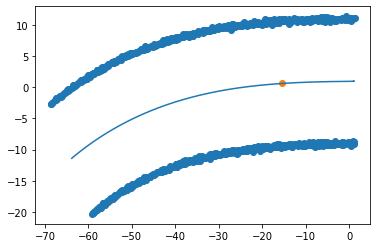

In [19]:
plt.plot(data['positions_x_ground_truth'], data['positions_y_ground_truth'])
plt.scatter(pc_array[:,0],pc_array[:,1])
plt.scatter(positions[100][0], positions[100][1])

In [56]:
spatial.distance.directed_hausdorff(one, two)

IndexError: tuple index out of range

In [1]:
import shutil
import config.config as config
import os

In [5]:
original = config.paths['data_path']+'\\map\\dummy_data.csv'
to = config.paths['data_path']+'\\dummy_data_moved.csv'

In [6]:
shutil.move(original, to)

'C:\\Users\\mso\\Documents\\Uni\\Partikelfilter-Vehicle-Lokalization\\particle_filter_lokalization\\data\\\\dummy_data_moved.csv'